## Library Imports

In [5]:
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df_purchase = pd.read_csv('purchase data.csv')

## Data Exploration

In [3]:
df_purchase.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,0,47,1,110866,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,0,47,1,110866,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0


## Data Segmentation

### Import Segmentation model

In [6]:
scaler = pickle.load(open('scaler.pickle','rb'))

In [7]:
pca = pickle.load(open('pca.pickle','rb'))

In [8]:
kmeans_pca = pickle.load(open('kmeans_pca.pickle','rb'))

### Standardization

In [10]:
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income','Occupation', 'Settlement size']]
df_purchase_seg_std = scaler.transform(features)

### PCA 

In [11]:
df_purchase_seg_pca = pca.transform(df_purchase_seg_std)

### K-means PCA

In [12]:
df_purchase_seg_kmeans_pca = kmeans_pca.predict(df_purchase_seg_pca)

In [13]:
df_purchase_predictors = df_purchase.copy()

In [14]:
df_purchase_predictors['Segment'] = df_purchase_seg_kmeans_pca

In [23]:
df_purchase_predictors.Segment.value_counts()

0    26162
2    14373
3     9892
1     8266
Name: Segment, dtype: int64

## Descriptive Analysis

### Data Analysis by Customer

In [26]:
df_purchase_predictors.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,47,1,110866,1,0,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,47,1,110866,1,0,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,0


In [30]:
n_visits = df_purchase_predictors[['ID','Incidence']].groupby(['ID'], as_index=False).count()
n_visits = n_visits.set_index('ID')
n_visits = n_visits.rename(columns={'Incidence':'N_Visits'})
n_visits.head()

,N_Visits
ID,
200000001,101
200000002,87
200000003,97
200000004,85
200000005,111


In [31]:
n_purchase = df_purchase_predictors[['ID','Incidence']].groupby(['ID'], as_index=False).sum()
n_purchase = n_purchase.set_index('ID')
n_purchase = n_purchase.rename(columns={'Incidence':'N_Purchase'})
n_purchase.head()

,N_Purchase
ID,
200000001,9
200000002,11
200000003,10
200000004,11
200000005,13


In [36]:
da_tab = n_visits.join(n_purchase)
da_tab['Purchase_Prop'] = da_tab['N_Purchase'] /da_tab['N_Visits']
da_tab.head()

In [39]:
cust_seg = df_purchase_predictors[['ID','Segment']].groupby(['ID'], as_index=False).mean()
cust_seg = cust_seg.set_index('ID')
cust_seg = cust_seg.rename(columns={'Incidence':'Segment'})

da_tab = da_tab.join(cust_seg)

In [42]:
da_tab.head()

,N_Visits,N_Purchase,Purchase_Prop,Segment
ID,,,,
200000001,101,9,0.089109,0
200000002,87,11,0.126437,1
200000003,97,10,0.103093,0
200000004,85,11,0.129412,0
200000005,111,13,0.117117,2


### Segment Proportions

In [46]:
seg_prop = da_tab[['N_Purchase','Segment']].groupby(['Segment']).count()/ da_tab.shape[0]
seg_prop = seg_prop.rename(columns={'N_Purchase':'Segment_Prop'})

In [47]:
seg_prop.head()

,Segment_Prop
Segment,
0,0.456
1,0.138
2,0.236
3,0.170


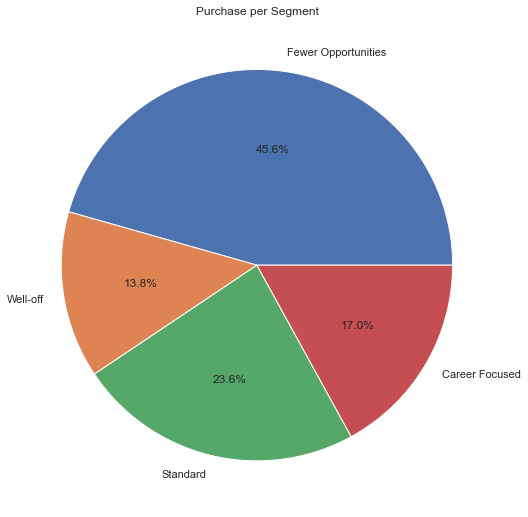

In [53]:
plt.figure(figsize=(12,9))
plt.title('Purchase per Segment')
plt.pie(seg_prop['Segment_Prop'], 
        labels=['Fewer Opportunities','Well-off','Standard','Career Focused'],
       autopct='%1.1f%%')
plt.show()